<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/fMRI/load_bonner_navigational_affordances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/projects/fMRI/load_bonner_navigational_affordances.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Data Loader

## Summary
Here we will load data from Bonner and Epstein, 2017 [1]. The data consist of fMRI responses to indoor scenes from scene selective regions (also whole brain) and navigational affordance behavioral responses in the form of representational dissimilarity matrices (RDMs) .




## Representational Similarity Analysis (RSA) [2]
RSA is a method to relate signals
from different source spaces (such as behavior, neural
responses, DNN activations) by abstracting signals from
separate source spaces into a common similarity space. For
this, in each source space, condition-specific responses are
compared to each other for dissimilarity (e.g., by calculating
Euclidean distances between signals), and the values are
aggregated in so-called representational dissimilarity matrices (RDMs) indexed in rows and columns by the conditions
compared. RDMs thus summarize the representational
geometry of the source space signals. Different from source
space signals themselves, RDMs from different sources
spaces are directly comparable to each other for similarity
and thus can relate signals from different spaces 

The figure below illustrates how RSA can be applied to different problems by comparing RDMs of different modalities/species.

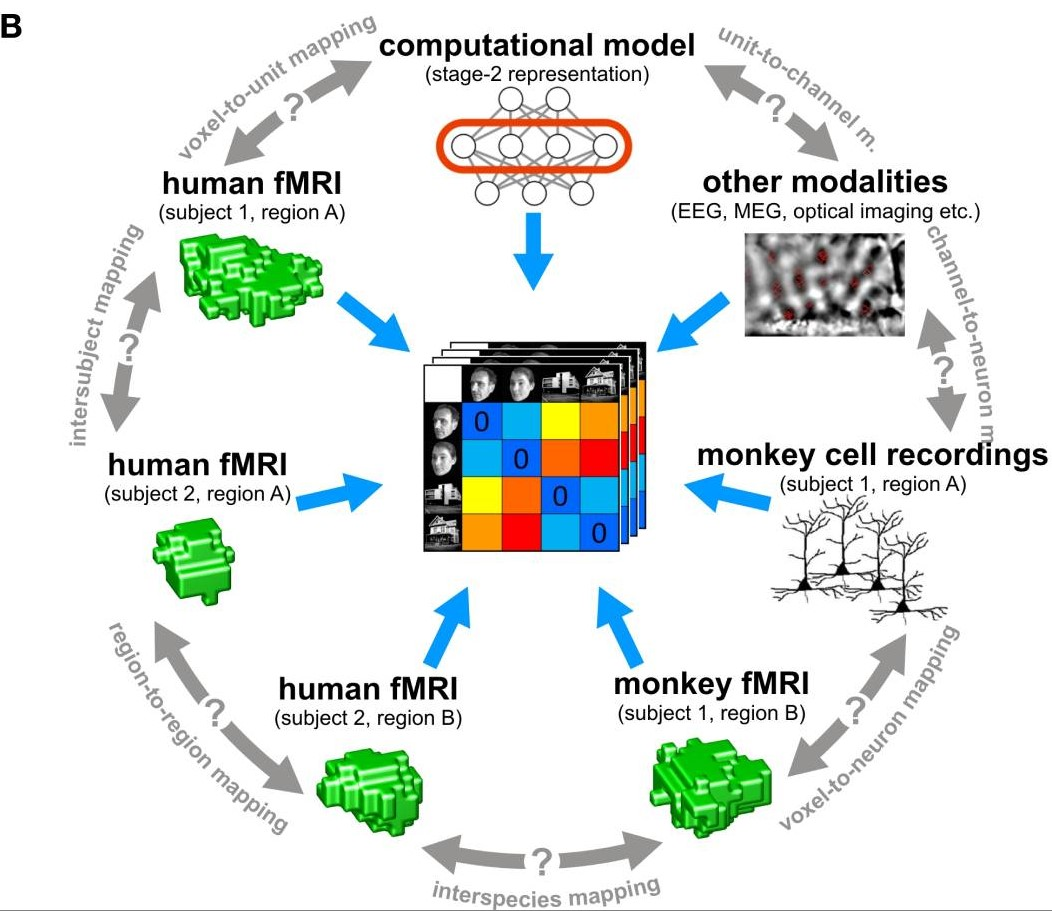

## Data from Bonner and Epstein
There are 50 images of indoor scene in this dataset. These images were used to collect fMRI and behavioral responses to investigate coding of navigational affordances in the human visual system.



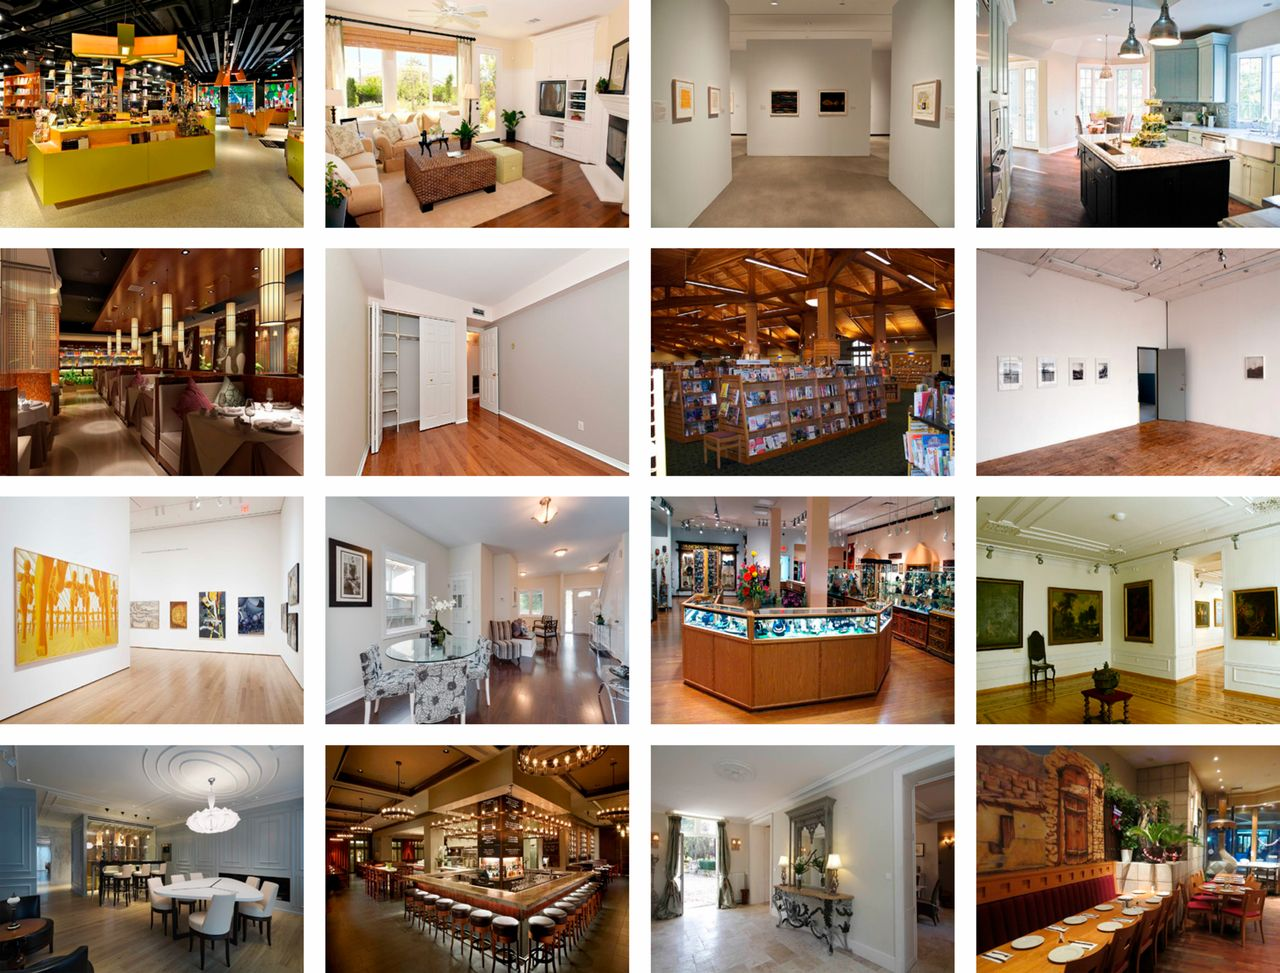

The images above show examples of complex, natural environments used as stimuli. All images were eye-level photographs of indoor environments with clear navigational paths extending from the implied viewing position.



In [ ]:
# @title Install dependencies
!pip install nilearn --quiet

In [ ]:
# Imports
import glob
import h5py
import cv2
import time
import h5py
import urllib
import random
import pickle
import argparse

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

import nilearn
from nilearn import plotting

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable as V
from torchvision import transforms as trn

In [ ]:
# @title Data download
import os, requests, zipfile, subprocess

def Unzip(fname, destinationDirectory):
  try:
    with zipfile.ZipFile(fname, 'r') as zipObj:
      # Extract all the contents of zip file in different directory
      zipObj.extractall(destinationDirectory)
  except:
    print("An exception occurred extracting with Python ZipFile library.")
    print("Attempting to extract using 7zip")
    subprocess.Popen(["7z", "e",
                      f"{fname}",
                      f"-o{destinationDirectory}",
                      "-y"])


fnames = ['rdms.zip', 'affordances.zip']
urls = ['https://osf.io/dsnq6/download', 'https://osf.io/zcgub/download']
dests = ['rdms/', 'affordances/']
for fname, url, dest in zip(fnames, urls, dests):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, 'wb') as fd:
          fd.write(r.content)
        Unzip(fname, dest)
        print(f'Download/Extraction of {fname} has been completed!')

An exception occurred extracting with Python ZipFile library.
Attempting to extract using 7zip
Download/Extraction of rdms.zip has been completed!



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs AMD EPYC 7763 64-Core Processor                 (A00F11),ASM,AES-NI)

Scanning the drive for archives:
1 file, 3339449461 bytes (3185 MiB)

Extracting archive: rdms.zip


Download/Extraction of affordances.zip has been completed!


In [ ]:
# @title load mat file

def loadmat(matfile):
  """Function to load .mat files.
  Parameters
  ----------
  matfile : str
      path to `matfile` containing fMRI data for a given trial.
  Returns
  -------
  dict
      dictionary containing data in key 'vol' for a given trial.
  """
  try:
    f = h5py.File(matfile)
  except (IOError, OSError):
    return sio.loadmat(matfile)
  else:
    return {name: np.transpose(f.get(name)) for name in f.keys()}

## fMRI RDMs

The fMRI data provided is available in form of RDMs. The regions of interest (ROI) investigated include two scene selective regions: parahippocampal place area (PPA) and occipital place area (OPA). If you are interested please watch a brief [video from Nancy Kanwisher](https://www.youtube.com/watch?v=EWK_hLrytQI) about these ROIs. Early visual cortex (EVC) RDM is also provided.  

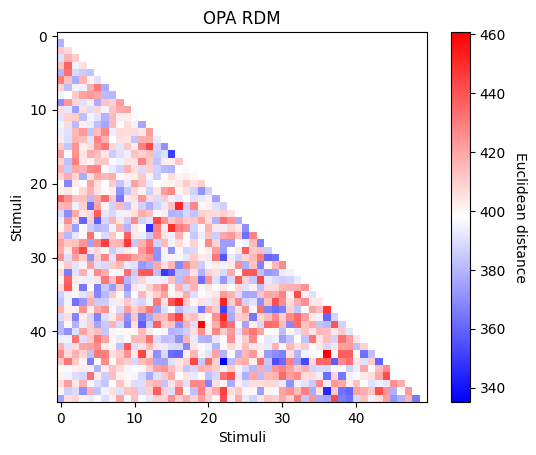

In [ ]:
# @title loading fMRI RDMs
# Enter ROI field
ROI = 'OPA' # @param ["OPA", "PPA","EVC"]

# Load ROI RDM (num_stimulus x num_stimulus numpy array)
ROI_RDM = loadmat(f"rdms/{ROI}.mat")["rdm"]

# Since the matrix is symmetric we set upper triangular values to NaN
ROI_RDM[np.triu_indices(ROI_RDM.shape[0], 1)] = np.nan

# plot the RDM
plt.imshow(ROI_RDM, cmap="bwr")
plt.title(ROI + " RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Euclidean distance', rotation=270)
plt.show()

## Navigational affordance (behavioral) RDM
To measure the navigational affordances, subjects indicated with a computer mouse the paths that they would take to walk through each environment starting from the bottom of the image. From these responses, probabilistic maps of the navigational paths through each scene were created. Then  histograms of these navigational probability measurements in one-degree angular bins over a range of directions radiating from the starting point of the paths were constructed. These histograms approximate a probabilistic affordance map of potential navigational paths radiating from the perspective of the viewer.

RDM for the navigational-affordance model were constructed through pairwise comparisons of the affordance histograms.

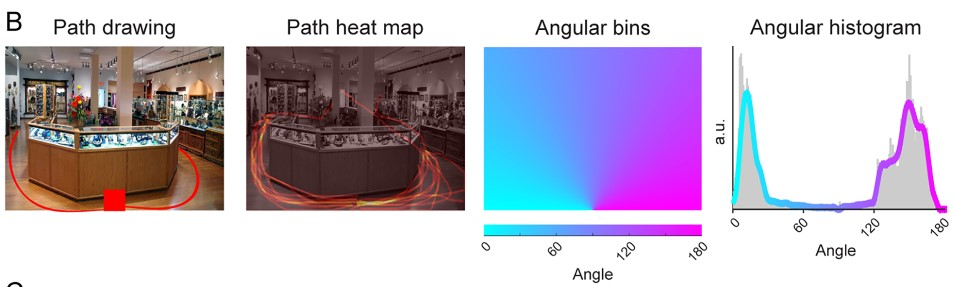

### Load and plot trajectories data

`Trajs.mat` contain data on the trajectories drawn by subjects during the evaluation phase before main experiment. The data is organised like `[n_images, heigth, width, n_evaluators]` There is a data on 173 images, of which 50 were presented to the participants. The filenames are stored as  `dtype`.


In [ ]:
trajs = loadmat('affordances/Trajs.mat')['Trajs']
fnames = trajs.dtype.names  # filenames get loaded as custom dtypes due and type of array is initialy np.void due to peculiarites of how it was saved in Matlab.
trajs = np.asarray(trajs[0][0].tolist())  # turn np.void into float32
trajs.shape

(173, 384, 512, 10)

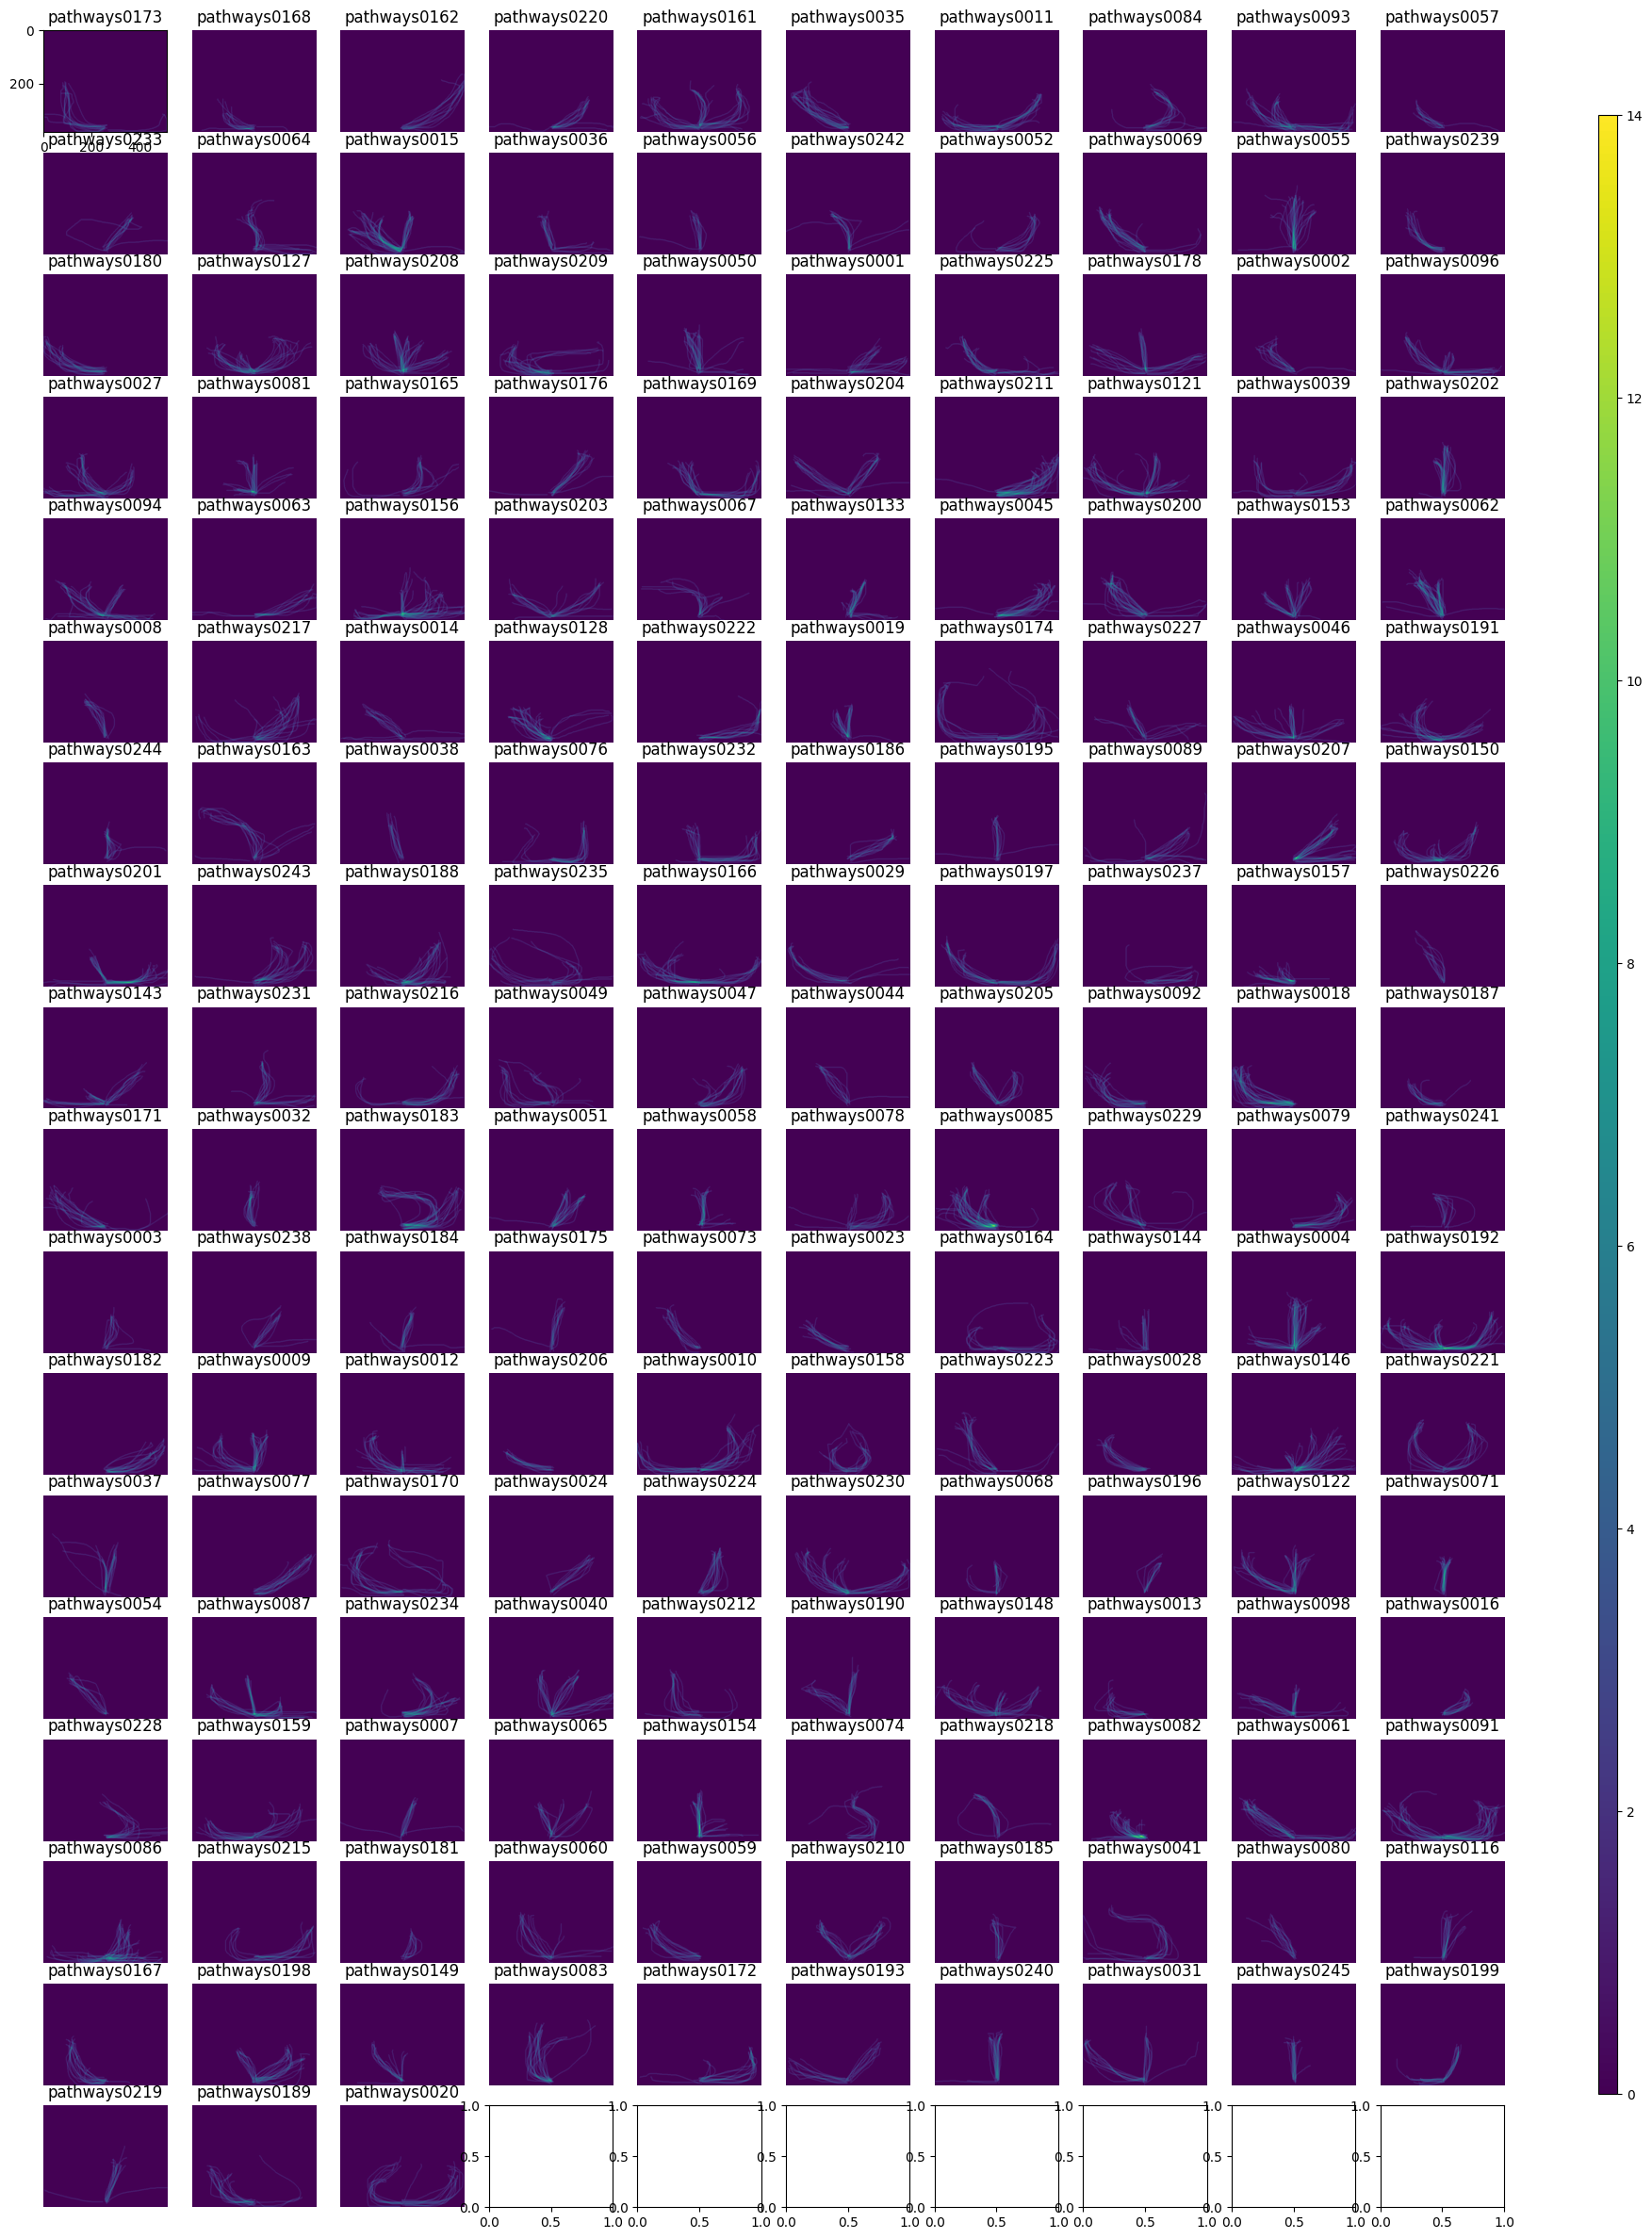

In [ ]:
fig, ax = plt.subplots(18, 10, figsize=(20, 30))

vmax = np.max(np.sum(trajs, axis=-1))  # make all images share the same scale
for a, tr in enumerate(trajs):
  i = ax.flat[a].imshow(np.sum(tr, axis=-1),
                        aspect='auto', vmin=0, vmax=vmax)  # plot the sum of trajectories over evaluators
  if a !=0:
    ax.flat[a].set_axis_off()  # leave axis only on the first subplot
  ax.flat[a].set_title(fnames[a])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
fig.colorbar(i, cax=cbar_ax)

`allPaths.mat` contains data on paths drawn during evaluation phase for images presented to participants. The paths are already summed between evaluators.

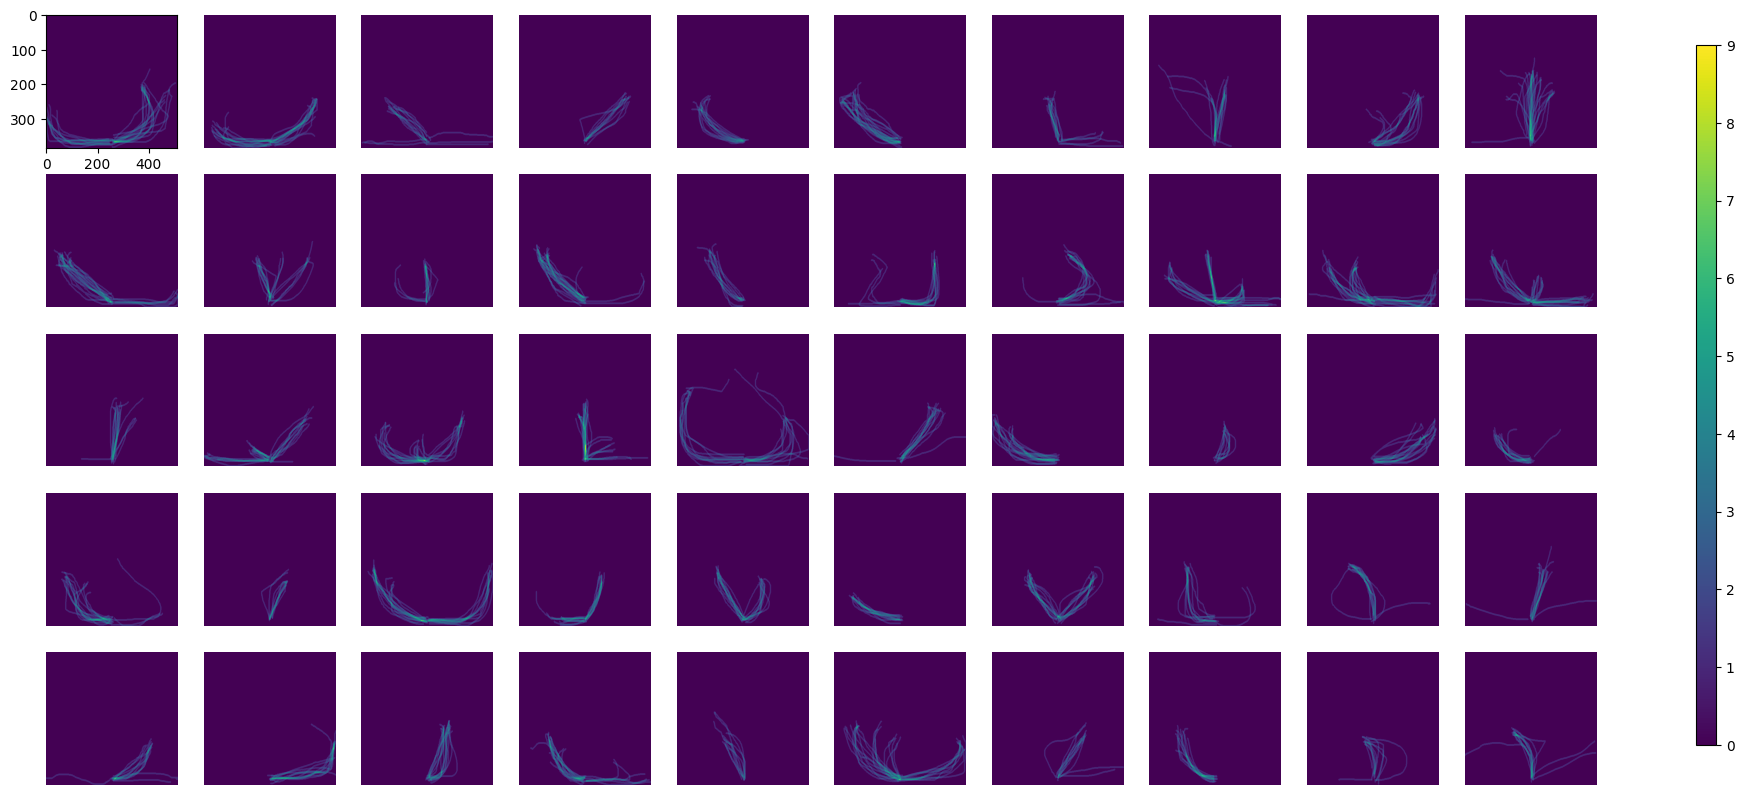

In [ ]:
paths = loadmat('affordances/allPaths.mat')
fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for a in range(50):
  i = ax.flat[a].imshow(paths['allPaths'][:, :, a],
                        aspect='auto',
                        vmin=0,
                        vmax=np.max(paths['allPaths'])
                        )
  if a !=0:
    ax.flat[a].set_axis_off()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
fig.colorbar(i, cax=cbar_ax)
fig.show()

`binCounts.mat` contains angular histogram for all images, calculated as per [1].

In [ ]:
angular_hist = loadmat('affordances/binCounts.mat')['binCounts']
angular_hist.shape

(173, 180)

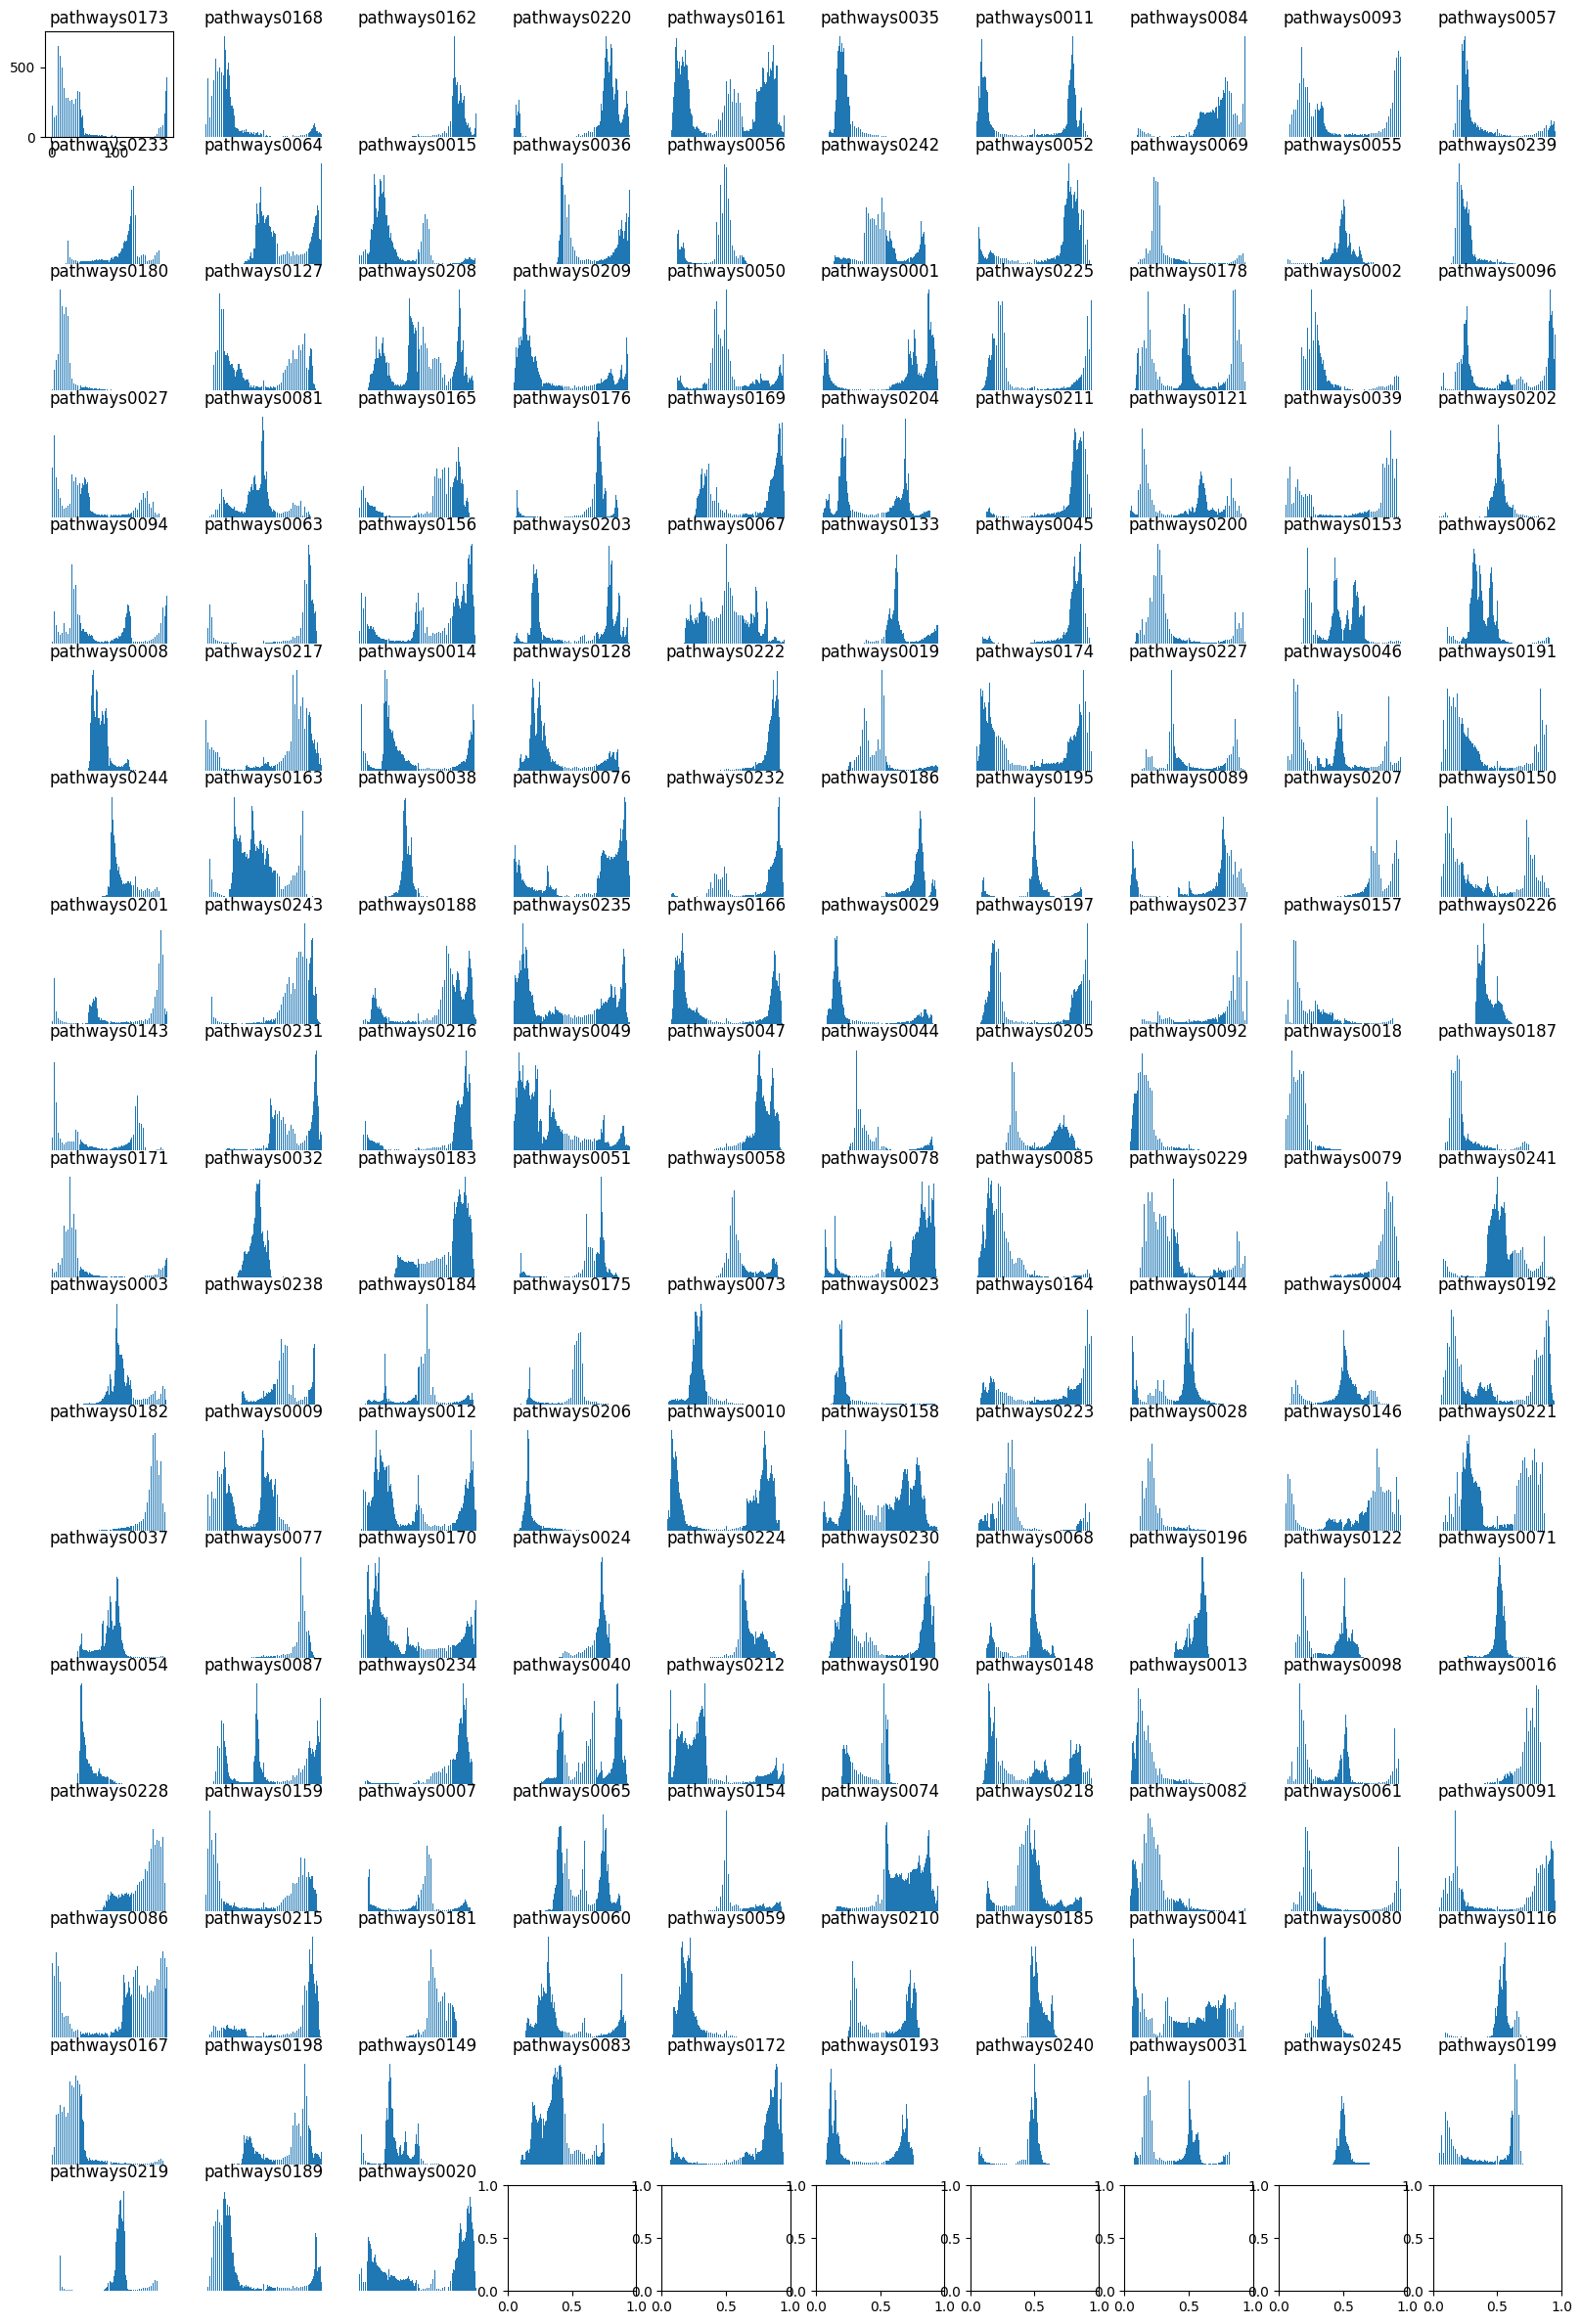

In [ ]:
fig, ax = plt.subplots(18, 10, figsize=(20, 30))

for a, tr in enumerate(trajs):
  i = ax.flat[a].bar(range(angular_hist.shape[1]), angular_hist[a])
  if a !=0:
    ax.flat[a].set_axis_off()
  ax.flat[a].set_title(fnames[a])
fig.show()

Subset affordances data for images used in the experiment and plot paths over images

    `fnames_exp` array of 50 strings 
    `trajs_exp` [50 images x height x width x 10 evaluators]
    `angular_hist_exp` angular histograms data with 1-degree bins, [50 images x 180 degrees]
the order of affordances and images is preserved


In [ ]:
stim_fnames = [a.split('.')[0] for a in os.listdir('rdms/stimuli')]
fnames_exp_mask = [True if a in stim_fnames else False for a in fnames]  #  make a boolean mask to select trajectories for images,

fnames_exp = np.array(fnames)[fnames_exp_mask]  # same order as affordances
trajs_exp = trajs[fnames_exp_mask]
angular_hist_exp = angular_hist[fnames_exp_mask]

--
Path = rdms.zip
Type = zip
Physical Size = 3339449461

Everything is Ok

Folders: 1
Files: 56
Size:       4915270898
Compressed: 3339449461


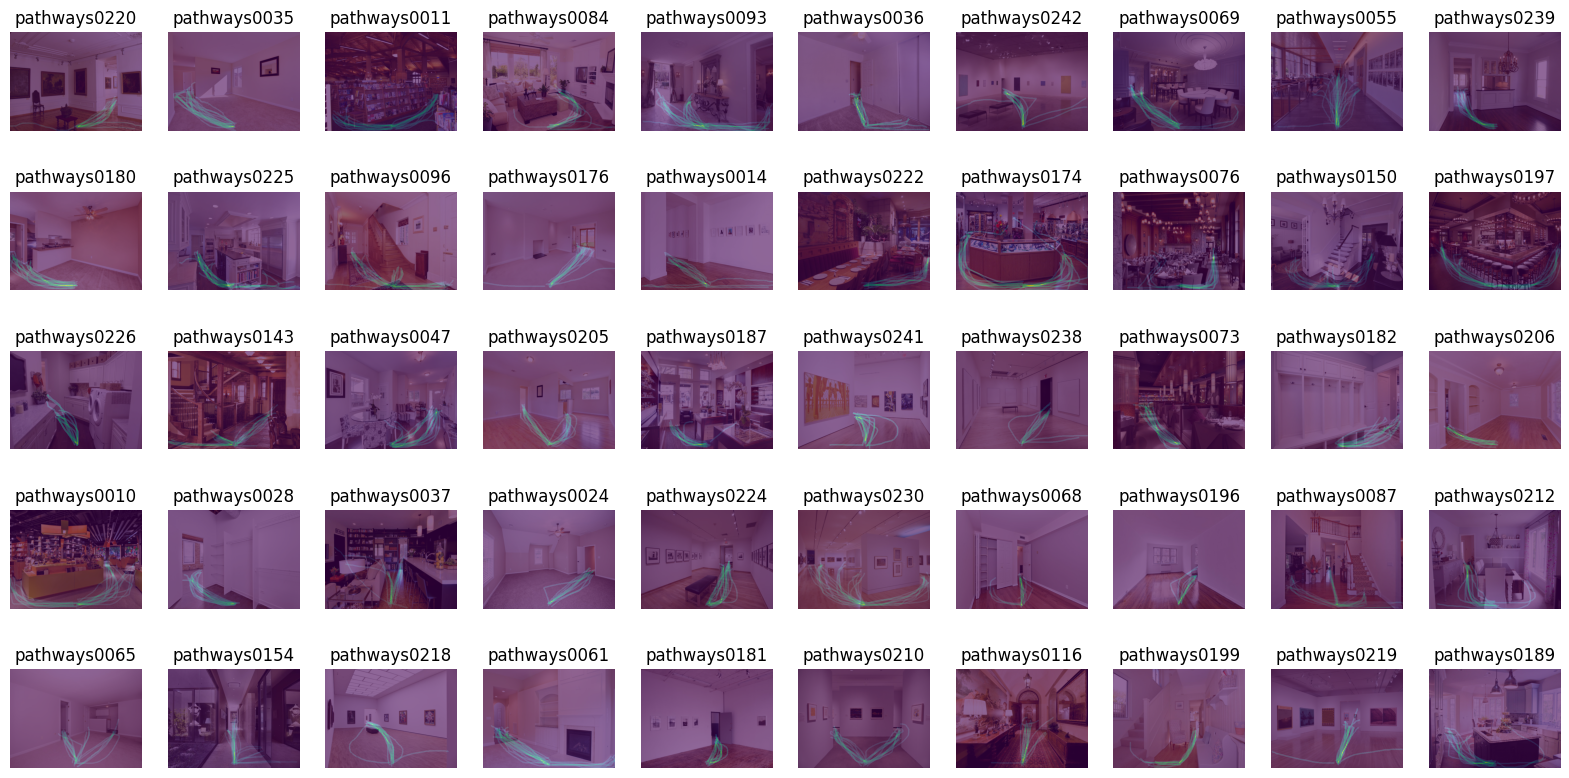

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
for a in range(50):
  im = Image.open(f'rdms/stimuli/{fnames_exp[a]}.jpg')
  scaled_img = np.kron(np.sum(trajs_exp[a], axis=-1), np.ones((2, 2)))  # images are 1024*768
  i = ax.flat[a].imshow(im)
  ax.flat[a].imshow(scaled_img, alpha=0.6)
  ax.flat[a].set_title(fnames_exp[a])
  ax.flat[a].set_axis_off()
fig.show()

# Load behavioral RDM

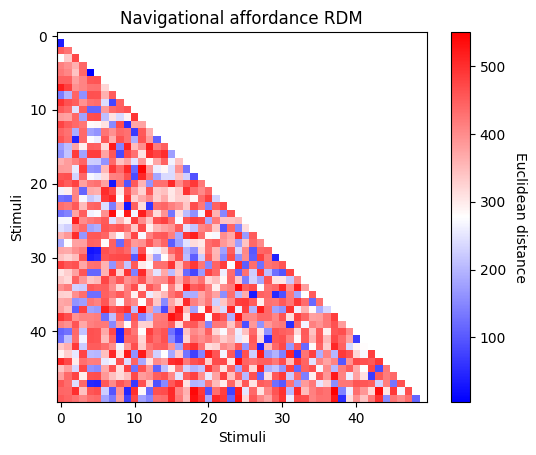

In [ ]:
# @title Loading behavioral RDM

# Load ROI RDM (num_stimulus x num_stimulus numpy array)
behavioral_RDM = loadmat("rdms/NAM.mat")["rdm"]

# Since the matrix is symmetric we set upper triangular values to NaN
behavioral_RDM[np.triu_indices(behavioral_RDM.shape[0], 1)] = np.nan

# plot the RDM
plt.imshow(behavioral_RDM, cmap="bwr")
plt.title("Navigational affordance RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Euclidean distance', rotation=270)
plt.show()

## Searchlight RDMs


In [ ]:
# @title Load searchlight RDM
all_sub_sl_rdm = np.load('rdms/all_sub_slrdms.npy')

Searchlight RDM is in shape *n_subjects x n_searchlights x n_images x n_images*

## Mapping searchlight result (random) to voxels

In [ ]:
# @title Searchlight utils
def readnii(niifile):
  """
  Load nifti file as numpy array
  """
  img = nib.load(niifile)
  img_np = np.array(img.dataobj)
  return img_np


def get_blocks(mask,sl_rad=1, max_blk_edge=10):
  """Divide the volume into a set of blocks
  Ignore blocks that have no active voxels in the mask
  Parameters
  ----------
  mask: a boolean 3D array which is true at every active voxel
  Returns
  -------
  list of tuples containing block information:
      - a triple containing top left point of the block and
      - a triple containing the size in voxels of the block
  """
  blocks = []
  outerblk = max_blk_edge + 2*sl_rad
  for i in range(0, mask.shape[0], max_blk_edge):
    for j in range(0, mask.shape[1], max_blk_edge):
      for k in range(0, mask.shape[2], max_blk_edge):
        block_shape = mask[i:i+outerblk,
                            j:j+outerblk,
                            k:k+outerblk
                            ].shape
        if np.any(mask[i + sl_rad:i + block_shape[0] - sl_rad,
                       j + sl_rad:j + block_shape[1] - sl_rad,
                       k + sl_rad:k + block_shape[2] - sl_rad]):
          blocks.append(((i, j, k), block_shape))
  return blocks


def get_block_data(mat, block):
  """Retrieve a block from a 3D or 4D volume
  Parameters
  ----------
  mat: a 3D or 4D volume
  block: a tuple containing block information:
    - a triple containing the lowest-coordinate voxel in the block
    - a triple containing the size in voxels of the block
  Returns
  -------
  In the case of a 3D array, a 3D subarray at the block location
  In the case of a 4D array, a 4D subarray at the block location,
  including the entire fourth dimension.
  """
  (pt, sz) = block
  if len(mat.shape) == 3:
    return mat[pt[0]:pt[0] + sz[0],
               pt[1]:pt[1] + sz[1],
               pt[2]:pt[2] + sz[2]].copy()
  elif len(mat.shape) == 4:
    return mat[pt[0]:pt[0] + sz[0],
               pt[1]:pt[1] + sz[1],
               pt[2]:pt[2] + sz[2], :].copy()


def blocks2sl(brain_mask,sl_result,sl_rad,max_blk_edge):
  """
  maps searchlight results in blocks to voxels
  """
  mask = readnii(brain_mask)
  blocks = get_blocks(mask,sl_rad=sl_rad,max_blk_edge=max_blk_edge)

  # Coalesce results
  outmat = np.empty(mask.shape, dtype=object).astype(float)

  for i in range(sl_result.shape[0]):
    pt = blocks[i][0]
    mat = blocks[i][1]
    coords = np.s_[pt[0] + sl_rad:pt[0] + sl_rad + mat[0],
                   pt[1] + sl_rad:pt[1] + sl_rad + mat[1],
                   pt[2] + sl_rad:pt[2] + sl_rad + mat[2]
                   ]
    outmat[coords] = sl_result[i]
  return outmat


def save_searchlight_nii(brain_mask, data, save_path,
                         sl_rad=1, max_blk_edge=2):
  """maps searchlight result to voxels and saves it as nifti file.

  Parameters
  ----------
  brain_mask : string
      path to nii file of brain mask
  data : np.array
      searchlight results to be mapped back on brain
  save_path : string
      path to save resulting searchlight nii file
  max_blk_edge : int
      searchlight parameter

  Returns
  -------
  None

  """
  img = nib.load(brain_mask)
  functional_map = blocks2sl(brain_mask, data, sl_rad, max_blk_edge)
  task_specificity_map_nii = nib.Nifti1Image(functional_map, img.affine,
                                             img.header)
  nib.save(task_specificity_map_nii, save_path)

In [ ]:
# @title Mapping random searchlight results to brain for visualization

# number of searchlights
num_sl = all_sub_sl_rdm.shape[1]

# generate results using normal distribution
mean = 0
std = 1
random_sl_result = np.random.normal(mean, std, num_sl)

# map the searchlights into voxels and save results as nifti file
brain_mask = 'rdms/mask.nii'
nii_save_path = 'rdms/random_sl.nii'
brain_map = save_searchlight_nii(brain_mask, random_sl_result, nii_save_path)

/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:1471: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


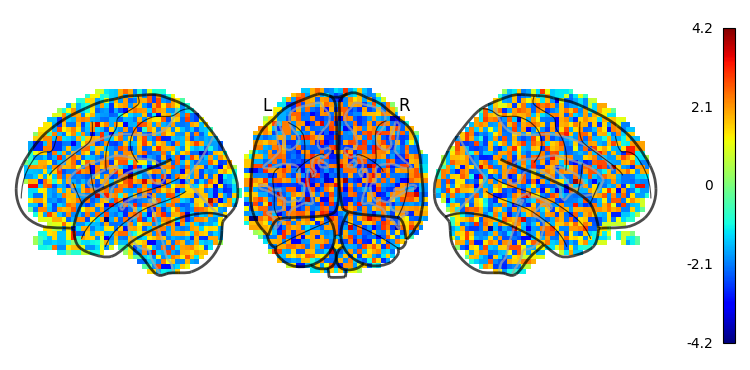

In [ ]:
# @title Visualing random searchlight result
plotting.plot_glass_brain(nii_save_path, plot_abs=False, colorbar=True,
                          display_mode='lyr', cmap ="jet", threshold=0.01)

# Example Analyses
Here we correlate Navigational Affordances model(NAM) RDM with fMRI RDMs to find out which brain region (ROI/searchlight) has representation similar to NAM.

##fMRI-behavior comparison (ROIs)
Here our goal is to find out which ROI has representation similar to NAM.

In [ ]:
# @title RDM Comparison functions

from scipy.stats import spearmanr

def RSA_spearman(rdm1,rdm2):
    """
    computes and returns the spearman correlation between lower triangular
    part of the input rdms. We only need to compare either lower or upper
    triangular part of the matrix as RDM is symmetric
    """
    # get lower triangular part of the RDM1
    lt_rdm1 = get_lowertriangular(rdm1)
    # get lower triangular part of the RDM1
    lt_rdm2 = get_lowertriangular(rdm2)
    # return Spearman's correlation between lower triangular part of rdm1 & rdm2
    return spearmanr(lt_rdm1, lt_rdm2)[0]

def get_lowertriangular(rdm):
    """
    returns lower triangular part of the matrix
    """
    num_conditions = rdm.shape[0]
    return rdm[np.tril_indices(num_conditions,-1)]

In [ ]:
ROIs = ["EVC","PPA","OPA"]
correlation = []

# Calculate correlation between ROI RDM and behavioral RDM for 3 ROIs
for ROI in ROIs:
  ROI_RDM = loadmat(f"rdms/{ROI}.mat")["rdm"]
  correlation.append(RSA_spearman(behavioral_RDM, ROI_RDM))

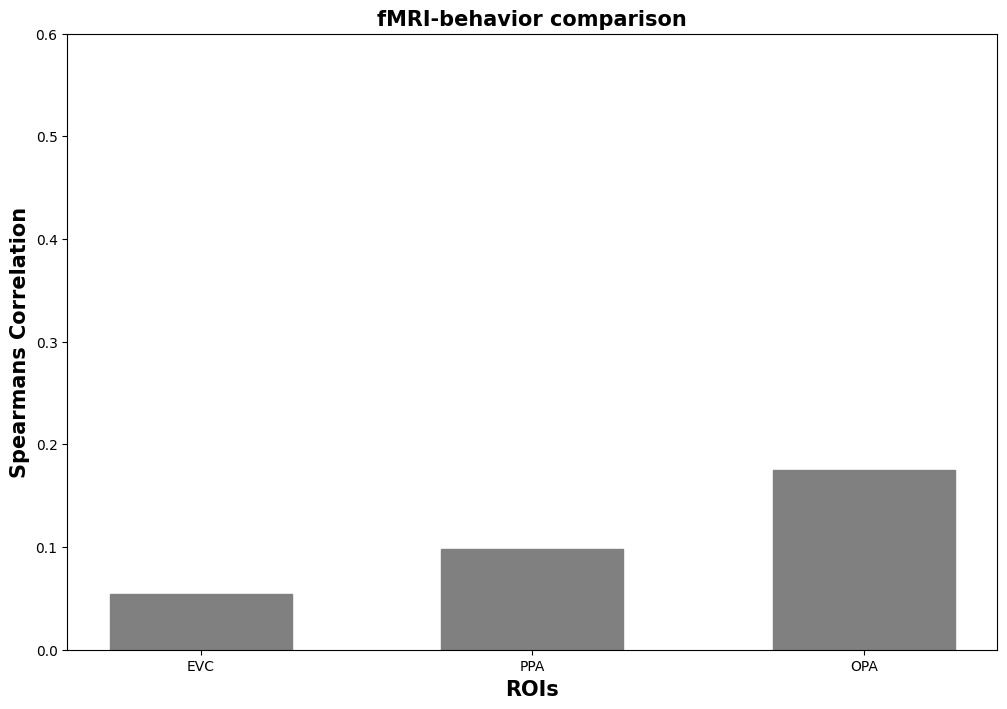

In [ ]:
####### bar plot showing correlation between behavioral and ROI RDMs ###########
barWidth = 0.55
fig = plt.subplots(figsize =(12, 8))
br = np.arange(len(ROIs))
plt.bar(br, correlation, color='gray', width=barWidth, edgecolor ='grey')
plt.xlabel('ROIs', fontweight='bold', fontsize=15)
plt.ylabel('Spearmans Correlation', fontweight='bold', fontsize=15)
# Adding Xticks
plt.xticks([r for r in range(len(ROIs))], ROIs)
plt.ylim(0, 0.6)
plt.title("fMRI-behavior comparison", fontweight='bold', fontsize=15)
plt.show()
################################################################################

## fMRI-behavior comparison (searchlight)
Here our goal is to find out which brain regions have representation similar to NAM by comparing behavioral RDM with searchlight RDMs over the whole brain.

In [ ]:
# @title Comparing behavioral RDM with searchlight RDM
# select subject
sub_id = "1"  # @param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]

s = int(sub_id) - 1
# get number of subjects
num_subs = all_sub_sl_rdm.shape[0]
# get number of searchlights
num_sl = all_sub_sl_rdm.shape[1]

sub_sl_correlation = []
# Calculate correlation between searchlight RDM and behavioral RDM for all searchlights

for i in tqdm(range(num_sl)):
  sub_sl_correlation.append(RSA_spearman(behavioral_RDM,
                                         all_sub_sl_rdm[s, i, :, :]))

# List to numpy array
sub_sl_correlation = np.array(sub_sl_correlation)

  0%|          | 0/30679 [00:00<?, ?it/s]

  0%|          | 86/30679 [00:00<00:35, 858.27it/s]

  1%|          | 172/30679 [00:00<00:36, 845.77it/s]

  1%|          | 257/30679 [00:00<00:36, 824.76it/s]

  1%|          | 340/30679 [00:00<00:36, 826.67it/s]

  1%|▏         | 423/30679 [00:00<00:37, 807.50it/s]

  2%|▏         | 507/30679 [00:00<00:36, 817.58it/s]

  2%|▏         | 592/30679 [00:00<00:36, 827.53it/s]

  2%|▏         | 678/30679 [00:00<00:35, 835.34it/s]

  2%|▏         | 764/30679 [00:00<00:35, 841.92it/s]

  3%|▎         | 850/30679 [00:01<00:35, 845.89it/s]

  3%|▎         | 936/30679 [00:01<00:35, 848.69it/s]

  3%|▎         | 1021/30679 [00:01<00:34, 848.72it/s]

  4%|▎         | 1107/30679 [00:01<00:34, 850.27it/s]

  4%|▍         | 1193/30679 [00:01<00:34, 848.01it/s]

  4%|▍         | 1278/30679 [00:01<00:34, 845.48it/s]

  4%|▍         | 1365/30679 [00:01<00:34, 852.62it/s]

  5%|▍         | 1453/30679 [00:01<00:34, 858.34it/s]

  5%|▌         | 1541/30679 [00:01<00:33, 863.16it/s]

  5%|▌         | 1629/30679 [00:01<00:33, 866.33it/s]

  6%|▌         | 1717/30679 [00:02<00:33, 868.43it/s]

  6%|▌         | 1805/30679 [00:02<00:33, 869.25it/s]

  6%|▌         | 1892/30679 [00:02<00:33, 867.48it/s]

  6%|▋         | 1979/30679 [00:02<00:33, 866.03it/s]

  7%|▋         | 2066/30679 [00:02<00:33, 864.17it/s]

  7%|▋         | 2153/30679 [00:02<00:33, 861.88it/s]

  7%|▋         | 2240/30679 [00:02<00:33, 860.84it/s]

  8%|▊         | 2328/30679 [00:02<00:32, 863.74it/s]

  8%|▊         | 2415/30679 [00:02<00:32, 860.96it/s]

  8%|▊         | 2503/30679 [00:02<00:32, 864.03it/s]

  8%|▊         | 2590/30679 [00:03<00:32, 865.48it/s]

  9%|▊         | 2678/30679 [00:03<00:32, 867.01it/s]

  9%|▉         | 2765/30679 [00:03<00:32, 864.87it/s]

  9%|▉         | 2853/30679 [00:03<00:32, 866.73it/s]

 10%|▉         | 2940/30679 [00:03<00:31, 867.59it/s]

 10%|▉         | 3028/30679 [00:03<00:31, 868.61it/s]

 10%|█         | 3115/30679 [00:03<00:32, 858.51it/s]

 10%|█         | 3203/30679 [00:03<00:31, 862.06it/s]

 11%|█         | 3291/30679 [00:03<00:31, 865.92it/s]

 11%|█         | 3380/30679 [00:03<00:31, 869.60it/s]

 11%|█▏        | 3468/30679 [00:04<00:31, 870.11it/s]

 12%|█▏        | 3556/30679 [00:04<00:31, 870.67it/s]

 12%|█▏        | 3644/30679 [00:04<00:31, 868.76it/s]

 12%|█▏        | 3731/30679 [00:04<00:31, 867.06it/s]

 12%|█▏        | 3819/30679 [00:04<00:30, 868.19it/s]

 13%|█▎        | 3906/30679 [00:04<00:30, 868.23it/s]

 13%|█▎        | 3993/30679 [00:04<00:31, 859.43it/s]

 13%|█▎        | 4080/30679 [00:04<00:30, 860.00it/s]

 14%|█▎        | 4167/30679 [00:04<00:30, 862.81it/s]

 14%|█▍        | 4255/30679 [00:04<00:30, 865.07it/s]

 14%|█▍        | 4342/30679 [00:05<00:30, 866.16it/s]

 14%|█▍        | 4429/30679 [00:05<00:30, 865.81it/s]

 15%|█▍        | 4516/30679 [00:05<00:30, 865.47it/s]

 15%|█▌        | 4603/30679 [00:05<00:30, 864.94it/s]

 15%|█▌        | 4691/30679 [00:05<00:29, 866.55it/s]

 16%|█▌        | 4779/30679 [00:05<00:29, 868.61it/s]

 16%|█▌        | 4867/30679 [00:05<00:29, 870.85it/s]

 16%|█▌        | 4955/30679 [00:05<00:29, 869.79it/s]

 16%|█▋        | 5042/30679 [00:05<00:29, 868.24it/s]

 17%|█▋        | 5130/30679 [00:05<00:29, 869.95it/s]

 17%|█▋        | 5218/30679 [00:06<00:29, 869.81it/s]

 17%|█▋        | 5306/30679 [00:06<00:29, 870.31it/s]

 18%|█▊        | 5394/30679 [00:06<00:29, 869.89it/s]

 18%|█▊        | 5481/30679 [00:06<00:28, 869.66it/s]

 18%|█▊        | 5568/30679 [00:06<00:28, 869.25it/s]

 18%|█▊        | 5656/30679 [00:06<00:28, 870.79it/s]

 19%|█▊        | 5744/30679 [00:06<00:29, 858.64it/s]

 19%|█▉        | 5830/30679 [00:06<00:29, 841.24it/s]

 19%|█▉        | 5915/30679 [00:06<00:30, 817.55it/s]

 20%|█▉        | 6003/30679 [00:06<00:29, 833.48it/s]

 20%|█▉        | 6091/30679 [00:07<00:29, 845.29it/s]

 20%|██        | 6179/30679 [00:07<00:28, 852.69it/s]

 20%|██        | 6266/30679 [00:07<00:28, 857.37it/s]

 21%|██        | 6353/30679 [00:07<00:28, 859.74it/s]

 21%|██        | 6440/30679 [00:07<00:28, 862.10it/s]

 21%|██▏       | 6528/30679 [00:07<00:27, 866.22it/s]

 22%|██▏       | 6616/30679 [00:07<00:27, 867.84it/s]

 22%|██▏       | 6704/30679 [00:07<00:27, 870.31it/s]

 22%|██▏       | 6792/30679 [00:07<00:27, 867.25it/s]

 22%|██▏       | 6879/30679 [00:08<00:27, 858.08it/s]

 23%|██▎       | 6966/30679 [00:08<00:27, 858.83it/s]

 23%|██▎       | 7052/30679 [00:08<00:27, 857.74it/s]

 23%|██▎       | 7138/30679 [00:08<00:27, 857.57it/s]

 24%|██▎       | 7224/30679 [00:08<00:27, 857.86it/s]

 24%|██▍       | 7311/30679 [00:08<00:27, 859.33it/s]

 24%|██▍       | 7398/30679 [00:08<00:27, 861.83it/s]

 24%|██▍       | 7486/30679 [00:08<00:26, 864.67it/s]

 25%|██▍       | 7573/30679 [00:08<00:26, 865.92it/s]

 25%|██▍       | 7661/30679 [00:08<00:26, 867.67it/s]

 25%|██▌       | 7748/30679 [00:09<00:26, 864.60it/s]

 26%|██▌       | 7835/30679 [00:09<00:26, 864.30it/s]

 26%|██▌       | 7922/30679 [00:09<00:26, 861.41it/s]

 26%|██▌       | 8009/30679 [00:09<00:26, 860.73it/s]

 26%|██▋       | 8096/30679 [00:09<00:26, 859.61it/s]

 27%|██▋       | 8183/30679 [00:09<00:26, 860.47it/s]

 27%|██▋       | 8271/30679 [00:09<00:25, 863.42it/s]

 27%|██▋       | 8358/30679 [00:09<00:25, 864.95it/s]

 28%|██▊       | 8445/30679 [00:09<00:25, 866.00it/s]

 28%|██▊       | 8532/30679 [00:09<00:25, 865.63it/s]

 28%|██▊       | 8619/30679 [00:10<00:25, 865.26it/s]

 28%|██▊       | 8706/30679 [00:10<00:25, 864.38it/s]

 29%|██▊       | 8793/30679 [00:10<00:25, 858.86it/s]

 29%|██▉       | 8879/30679 [00:10<00:25, 856.77it/s]

 29%|██▉       | 8965/30679 [00:10<00:25, 857.70it/s]

 30%|██▉       | 9052/30679 [00:10<00:25, 859.00it/s]

 30%|██▉       | 9139/30679 [00:10<00:25, 860.98it/s]

 30%|███       | 9226/30679 [00:10<00:24, 859.19it/s]

 30%|███       | 9314/30679 [00:10<00:24, 863.59it/s]

 31%|███       | 9402/30679 [00:10<00:24, 867.22it/s]

 31%|███       | 9490/30679 [00:11<00:24, 868.50it/s]

 31%|███       | 9577/30679 [00:11<00:24, 868.27it/s]

 32%|███▏      | 9664/30679 [00:11<00:24, 867.39it/s]

 32%|███▏      | 9751/30679 [00:11<00:24, 865.44it/s]

 32%|███▏      | 9838/30679 [00:11<00:24, 864.53it/s]

 32%|███▏      | 9925/30679 [00:11<00:24, 863.36it/s]

 33%|███▎      | 10013/30679 [00:11<00:23, 864.72it/s]

 33%|███▎      | 10100/30679 [00:11<00:23, 865.68it/s]

 33%|███▎      | 10187/30679 [00:11<00:23, 862.09it/s]

 33%|███▎      | 10274/30679 [00:11<00:23, 863.31it/s]

 34%|███▍      | 10361/30679 [00:12<00:23, 860.92it/s]

 34%|███▍      | 10448/30679 [00:12<00:24, 840.93it/s]

 34%|███▍      | 10534/30679 [00:12<00:23, 845.58it/s]

 35%|███▍      | 10620/30679 [00:12<00:23, 848.87it/s]

 35%|███▍      | 10706/30679 [00:12<00:23, 851.34it/s]

 35%|███▌      | 10793/30679 [00:12<00:23, 856.26it/s]

 35%|███▌      | 10881/30679 [00:12<00:23, 860.76it/s]

 36%|███▌      | 10969/30679 [00:12<00:22, 863.53it/s]

 36%|███▌      | 11057/30679 [00:12<00:22, 865.55it/s]

 36%|███▋      | 11145/30679 [00:12<00:22, 868.40it/s]

 37%|███▋      | 11233/30679 [00:13<00:22, 869.81it/s]

 37%|███▋      | 11320/30679 [00:13<00:22, 868.20it/s]

 37%|███▋      | 11407/30679 [00:13<00:22, 862.42it/s]

 37%|███▋      | 11494/30679 [00:13<00:22, 859.55it/s]

 38%|███▊      | 11580/30679 [00:13<00:22, 857.85it/s]

 38%|███▊      | 11668/30679 [00:13<00:22, 863.21it/s]

 38%|███▊      | 11756/30679 [00:13<00:21, 865.50it/s]

 39%|███▊      | 11843/30679 [00:13<00:22, 834.46it/s]

 39%|███▉      | 11930/30679 [00:13<00:22, 842.07it/s]

 39%|███▉      | 12015/30679 [00:13<00:22, 822.38it/s]

 39%|███▉      | 12103/30679 [00:14<00:22, 837.70it/s]

 40%|███▉      | 12190/30679 [00:14<00:21, 846.45it/s]

 40%|████      | 12276/30679 [00:14<00:21, 849.58it/s]

 40%|████      | 12362/30679 [00:14<00:21, 849.35it/s]

 41%|████      | 12449/30679 [00:14<00:21, 853.47it/s]

 41%|████      | 12537/30679 [00:14<00:21, 858.72it/s]

 41%|████      | 12625/30679 [00:14<00:20, 861.87it/s]

 41%|████▏     | 12713/30679 [00:14<00:20, 864.67it/s]

 42%|████▏     | 12800/30679 [00:14<00:20, 866.20it/s]

 42%|████▏     | 12888/30679 [00:14<00:20, 868.18it/s]

 42%|████▏     | 12976/30679 [00:15<00:20, 869.33it/s]

 43%|████▎     | 13063/30679 [00:15<00:20, 866.72it/s]

 43%|████▎     | 13150/30679 [00:15<00:20, 863.79it/s]

 43%|████▎     | 13237/30679 [00:15<00:20, 858.39it/s]

 43%|████▎     | 13324/30679 [00:15<00:20, 861.74it/s]

 44%|████▎     | 13412/30679 [00:15<00:19, 865.26it/s]

 44%|████▍     | 13500/30679 [00:15<00:19, 868.38it/s]

 44%|████▍     | 13588/30679 [00:15<00:19, 869.87it/s]

 45%|████▍     | 13676/30679 [00:15<00:19, 871.23it/s]

 45%|████▍     | 13764/30679 [00:16<00:19, 871.89it/s]

 45%|████▌     | 13852/30679 [00:16<00:19, 871.63it/s]

 45%|████▌     | 13940/30679 [00:16<00:19, 870.98it/s]

 46%|████▌     | 14028/30679 [00:16<00:19, 870.63it/s]

 46%|████▌     | 14116/30679 [00:16<00:19, 862.46it/s]

 46%|████▋     | 14203/30679 [00:16<00:20, 819.04it/s]

 47%|████▋     | 14290/30679 [00:16<00:19, 831.38it/s]

 47%|████▋     | 14378/30679 [00:16<00:19, 844.16it/s]

 47%|████▋     | 14466/30679 [00:16<00:18, 853.68it/s]

 47%|████▋     | 14554/30679 [00:16<00:18, 860.86it/s]

 48%|████▊     | 14642/30679 [00:17<00:18, 865.48it/s]

 48%|████▊     | 14730/30679 [00:17<00:18, 867.48it/s]

 48%|████▊     | 14817/30679 [00:17<00:18, 867.22it/s]

 49%|████▊     | 14904/30679 [00:17<00:18, 862.56it/s]

 49%|████▉     | 14991/30679 [00:17<00:18, 862.99it/s]

 49%|████▉     | 15078/30679 [00:17<00:18, 862.38it/s]

 49%|████▉     | 15166/30679 [00:17<00:17, 864.83it/s]

 50%|████▉     | 15254/30679 [00:17<00:17, 867.49it/s]

 50%|█████     | 15342/30679 [00:17<00:17, 869.31it/s]

 50%|█████     | 15430/30679 [00:17<00:17, 871.00it/s]

 51%|█████     | 15518/30679 [00:18<00:17, 871.47it/s]

 51%|█████     | 15606/30679 [00:18<00:17, 869.82it/s]

 51%|█████     | 15693/30679 [00:18<00:17, 867.66it/s]

 51%|█████▏    | 15780/30679 [00:18<00:17, 867.14it/s]

 52%|█████▏    | 15867/30679 [00:18<00:17, 866.04it/s]

 52%|█████▏    | 15954/30679 [00:18<00:17, 861.04it/s]

 52%|█████▏    | 16041/30679 [00:18<00:17, 825.12it/s]

 53%|█████▎    | 16127/30679 [00:18<00:17, 834.35it/s]

 53%|█████▎    | 16215/30679 [00:18<00:17, 847.31it/s]

 53%|█████▎    | 16302/30679 [00:18<00:16, 851.96it/s]

 53%|█████▎    | 16390/30679 [00:19<00:16, 860.06it/s]

 54%|█████▎    | 16478/30679 [00:19<00:16, 863.67it/s]

 54%|█████▍    | 16565/30679 [00:19<00:16, 864.81it/s]

 54%|█████▍    | 16653/30679 [00:19<00:16, 867.65it/s]

 55%|█████▍    | 16740/30679 [00:19<00:16, 868.15it/s]

 55%|█████▍    | 16828/30679 [00:19<00:15, 871.32it/s]

 55%|█████▌    | 16916/30679 [00:19<00:15, 869.36it/s]

 55%|█████▌    | 17003/30679 [00:19<00:16, 851.81it/s]

 56%|█████▌    | 17091/30679 [00:19<00:15, 859.27it/s]

 56%|█████▌    | 17179/30679 [00:19<00:15, 862.77it/s]

 56%|█████▋    | 17267/30679 [00:20<00:15, 865.92it/s]

 57%|█████▋    | 17354/30679 [00:20<00:15, 865.70it/s]

 57%|█████▋    | 17441/30679 [00:20<00:15, 864.58it/s]

 57%|█████▋    | 17528/30679 [00:20<00:15, 864.17it/s]

 57%|█████▋    | 17615/30679 [00:20<00:15, 865.47it/s]

 58%|█████▊    | 17703/30679 [00:20<00:14, 868.19it/s]

 58%|█████▊    | 17791/30679 [00:20<00:14, 868.62it/s]

 58%|█████▊    | 17878/30679 [00:20<00:14, 864.99it/s]

 59%|█████▊    | 17966/30679 [00:20<00:14, 867.00it/s]

 59%|█████▉    | 18053/30679 [00:20<00:14, 866.89it/s]

 59%|█████▉    | 18140/30679 [00:21<00:14, 865.90it/s]

 59%|█████▉    | 18227/30679 [00:21<00:14, 863.66it/s]

 60%|█████▉    | 18314/30679 [00:21<00:14, 862.89it/s]

 60%|█████▉    | 18401/30679 [00:21<00:14, 862.70it/s]

 60%|██████    | 18488/30679 [00:21<00:14, 864.58it/s]

 61%|██████    | 18575/30679 [00:21<00:13, 864.62it/s]

 61%|██████    | 18662/30679 [00:21<00:13, 865.56it/s]

 61%|██████    | 18749/30679 [00:21<00:13, 864.16it/s]

 61%|██████▏   | 18836/30679 [00:21<00:13, 864.11it/s]

 62%|██████▏   | 18924/30679 [00:21<00:13, 866.56it/s]

 62%|██████▏   | 19012/30679 [00:22<00:13, 868.50it/s]

 62%|██████▏   | 19099/30679 [00:22<00:13, 866.96it/s]

 63%|██████▎   | 19186/30679 [00:22<00:13, 866.04it/s]

 63%|██████▎   | 19273/30679 [00:22<00:13, 866.46it/s]

 63%|██████▎   | 19360/30679 [00:22<00:13, 866.13it/s]

 63%|██████▎   | 19447/30679 [00:22<00:12, 866.48it/s]

 64%|██████▎   | 19534/30679 [00:22<00:12, 865.21it/s]

 64%|██████▍   | 19621/30679 [00:22<00:12, 865.07it/s]

 64%|██████▍   | 19708/30679 [00:22<00:12, 860.35it/s]

 65%|██████▍   | 19795/30679 [00:23<00:12, 862.26it/s]

 65%|██████▍   | 19882/30679 [00:23<00:12, 863.62it/s]

 65%|██████▌   | 19969/30679 [00:23<00:12, 860.18it/s]

 65%|██████▌   | 20056/30679 [00:23<00:12, 859.96it/s]

 66%|██████▌   | 20143/30679 [00:23<00:12, 861.92it/s]

 66%|██████▌   | 20230/30679 [00:23<00:12, 863.58it/s]

 66%|██████▌   | 20317/30679 [00:23<00:11, 864.67it/s]

 67%|██████▋   | 20404/30679 [00:23<00:11, 864.92it/s]

 67%|██████▋   | 20491/30679 [00:23<00:11, 865.05it/s]

 67%|██████▋   | 20578/30679 [00:23<00:11, 861.88it/s]

 67%|██████▋   | 20665/30679 [00:24<00:11, 861.81it/s]

 68%|██████▊   | 20753/30679 [00:24<00:11, 864.86it/s]

 68%|██████▊   | 20840/30679 [00:24<00:11, 862.82it/s]

 68%|██████▊   | 20927/30679 [00:24<00:11, 863.34it/s]

 68%|██████▊   | 21014/30679 [00:24<00:11, 855.15it/s]

 69%|██████▉   | 21102/30679 [00:24<00:11, 860.93it/s]

 69%|██████▉   | 21190/30679 [00:24<00:10, 863.75it/s]

 69%|██████▉   | 21278/30679 [00:24<00:10, 867.00it/s]

 70%|██████▉   | 21366/30679 [00:24<00:10, 869.71it/s]

 70%|██████▉   | 21453/30679 [00:24<00:10, 869.60it/s]

 70%|███████   | 21540/30679 [00:25<00:10, 865.66it/s]

 70%|███████   | 21627/30679 [00:25<00:10, 865.82it/s]

 71%|███████   | 21714/30679 [00:25<00:10, 865.79it/s]

 71%|███████   | 21802/30679 [00:25<00:10, 867.52it/s]

 71%|███████▏  | 21890/30679 [00:25<00:10, 870.32it/s]

 72%|███████▏  | 21978/30679 [00:25<00:10, 869.43it/s]

 72%|███████▏  | 22066/30679 [00:25<00:09, 870.71it/s]

 72%|███████▏  | 22154/30679 [00:25<00:09, 870.85it/s]

 72%|███████▏  | 22242/30679 [00:25<00:09, 870.58it/s]

 73%|███████▎  | 22330/30679 [00:25<00:09, 871.77it/s]

 73%|███████▎  | 22418/30679 [00:26<00:09, 871.10it/s]

 73%|███████▎  | 22506/30679 [00:26<00:09, 856.66it/s]

 74%|███████▎  | 22593/30679 [00:26<00:09, 857.93it/s]

 74%|███████▍  | 22681/30679 [00:26<00:09, 861.48it/s]

 74%|███████▍  | 22769/30679 [00:26<00:09, 863.77it/s]

 75%|███████▍  | 22857/30679 [00:26<00:09, 867.12it/s]

 75%|███████▍  | 22945/30679 [00:26<00:08, 868.45it/s]

 75%|███████▌  | 23033/30679 [00:26<00:08, 870.30it/s]

 75%|███████▌  | 23121/30679 [00:26<00:08, 872.49it/s]

 76%|███████▌  | 23209/30679 [00:26<00:08, 874.51it/s]

 76%|███████▌  | 23297/30679 [00:27<00:08, 874.93it/s]

 76%|███████▌  | 23385/30679 [00:27<00:08, 869.61it/s]

 77%|███████▋  | 23472/30679 [00:27<00:08, 864.35it/s]

 77%|███████▋  | 23559/30679 [00:27<00:08, 864.64it/s]

 77%|███████▋  | 23646/30679 [00:27<00:08, 850.22it/s]

 77%|███████▋  | 23733/30679 [00:27<00:08, 854.50it/s]

 78%|███████▊  | 23820/30679 [00:27<00:07, 858.90it/s]

 78%|███████▊  | 23907/30679 [00:27<00:07, 860.48it/s]

 78%|███████▊  | 23994/30679 [00:27<00:07, 862.21it/s]

 78%|███████▊  | 24081/30679 [00:27<00:07, 862.69it/s]

 79%|███████▉  | 24168/30679 [00:28<00:07, 863.48it/s]

 79%|███████▉  | 24255/30679 [00:28<00:07, 864.02it/s]

 79%|███████▉  | 24342/30679 [00:28<00:07, 856.91it/s]

 80%|███████▉  | 24429/30679 [00:28<00:07, 859.69it/s]

 80%|███████▉  | 24517/30679 [00:28<00:07, 863.42it/s]

 80%|████████  | 24605/30679 [00:28<00:07, 865.73it/s]

 80%|████████  | 24693/30679 [00:28<00:06, 868.24it/s]

 81%|████████  | 24780/30679 [00:28<00:06, 868.38it/s]

 81%|████████  | 24868/30679 [00:28<00:06, 869.30it/s]

 81%|████████▏ | 24956/30679 [00:28<00:06, 870.00it/s]

 82%|████████▏ | 25044/30679 [00:29<00:06, 870.10it/s]

 82%|████████▏ | 25132/30679 [00:29<00:06, 868.50it/s]

 82%|████████▏ | 25219/30679 [00:29<00:06, 866.74it/s]

 82%|████████▏ | 25306/30679 [00:29<00:06, 867.30it/s]

 83%|████████▎ | 25394/30679 [00:29<00:06, 869.58it/s]

 83%|████████▎ | 25482/30679 [00:29<00:05, 870.40it/s]

 83%|████████▎ | 25570/30679 [00:29<00:05, 870.93it/s]

 84%|████████▎ | 25658/30679 [00:29<00:05, 871.11it/s]

 84%|████████▍ | 25746/30679 [00:29<00:05, 871.64it/s]

 84%|████████▍ | 25834/30679 [00:29<00:05, 872.37it/s]

 84%|████████▍ | 25922/30679 [00:30<00:05, 870.83it/s]

 85%|████████▍ | 26010/30679 [00:30<00:05, 866.98it/s]

 85%|████████▌ | 26098/30679 [00:30<00:05, 867.92it/s]

 85%|████████▌ | 26185/30679 [00:30<00:05, 858.88it/s]

 86%|████████▌ | 26273/30679 [00:30<00:05, 863.56it/s]

 86%|████████▌ | 26361/30679 [00:30<00:04, 866.31it/s]

 86%|████████▌ | 26448/30679 [00:30<00:04, 865.93it/s]

 86%|████████▋ | 26536/30679 [00:30<00:04, 867.44it/s]

 87%|████████▋ | 26624/30679 [00:30<00:04, 869.49it/s]

 87%|████████▋ | 26712/30679 [00:30<00:04, 870.58it/s]

 87%|████████▋ | 26800/30679 [00:31<00:04, 869.86it/s]

 88%|████████▊ | 26887/30679 [00:31<00:04, 866.85it/s]

 88%|████████▊ | 26974/30679 [00:31<00:04, 867.75it/s]

 88%|████████▊ | 27062/30679 [00:31<00:04, 869.33it/s]

 88%|████████▊ | 27150/30679 [00:31<00:04, 869.25it/s]

 89%|████████▉ | 27237/30679 [00:31<00:03, 868.59it/s]

 89%|████████▉ | 27324/30679 [00:31<00:03, 868.65it/s]

 89%|████████▉ | 27411/30679 [00:31<00:03, 867.07it/s]

 90%|████████▉ | 27498/30679 [00:31<00:03, 867.57it/s]

 90%|████████▉ | 27585/30679 [00:31<00:03, 868.11it/s]

 90%|█████████ | 27672/30679 [00:32<00:03, 867.92it/s]

 90%|█████████ | 27759/30679 [00:32<00:03, 864.94it/s]

 91%|█████████ | 27846/30679 [00:32<00:03, 866.28it/s]

 91%|█████████ | 27933/30679 [00:32<00:03, 866.50it/s]

 91%|█████████▏| 28020/30679 [00:32<00:03, 863.91it/s]

 92%|█████████▏| 28107/30679 [00:32<00:02, 864.70it/s]

 92%|█████████▏| 28195/30679 [00:32<00:02, 866.43it/s]

 92%|█████████▏| 28282/30679 [00:32<00:02, 867.17it/s]

 92%|█████████▏| 28370/30679 [00:32<00:02, 870.27it/s]

 93%|█████████▎| 28458/30679 [00:33<00:02, 870.29it/s]

 93%|█████████▎| 28546/30679 [00:33<00:02, 869.63it/s]

 93%|█████████▎| 28633/30679 [00:33<00:02, 868.51it/s]

 94%|█████████▎| 28720/30679 [00:33<00:02, 868.20it/s]

 94%|█████████▍| 28807/30679 [00:33<00:02, 866.00it/s]

 94%|█████████▍| 28894/30679 [00:33<00:02, 865.01it/s]

 94%|█████████▍| 28981/30679 [00:33<00:01, 862.91it/s]

 95%|█████████▍| 29068/30679 [00:33<00:01, 864.02it/s]

 95%|█████████▌| 29155/30679 [00:33<00:01, 863.62it/s]

 95%|█████████▌| 29243/30679 [00:33<00:01, 865.33it/s]

 96%|█████████▌| 29330/30679 [00:34<00:01, 866.64it/s]

 96%|█████████▌| 29417/30679 [00:34<00:01, 865.59it/s]

 96%|█████████▌| 29504/30679 [00:34<00:01, 863.81it/s]

 96%|█████████▋| 29592/30679 [00:34<00:01, 865.46it/s]

 97%|█████████▋| 29680/30679 [00:34<00:01, 866.68it/s]

 97%|█████████▋| 29767/30679 [00:34<00:01, 866.45it/s]

 97%|█████████▋| 29854/30679 [00:34<00:01, 824.03it/s]

 98%|█████████▊| 29941/30679 [00:34<00:00, 834.82it/s]

 98%|█████████▊| 30029/30679 [00:34<00:00, 845.92it/s]

 98%|█████████▊| 30117/30679 [00:34<00:00, 852.94it/s]

 98%|█████████▊| 30205/30679 [00:35<00:00, 858.05it/s]

 99%|█████████▊| 30292/30679 [00:35<00:00, 859.52it/s]

 99%|█████████▉| 30379/30679 [00:35<00:00, 859.43it/s]

 99%|█████████▉| 30466/30679 [00:35<00:00, 861.61it/s]

100%|█████████▉| 30553/30679 [00:35<00:00, 862.88it/s]

100%|█████████▉| 30640/30679 [00:35<00:00, 863.59it/s]

100%|██████████| 30679/30679 [00:35<00:00, 862.08it/s]

In [ ]:
# @title Mapping the searchlight results to brain for visualization
brain_mask = 'rdms/mask.nii'
nii_save_path = 'rdms/navigational_affordance_sl.nii'
brain_map = save_searchlight_nii(brain_mask,
                                 sub_sl_correlation,
                                 nii_save_path)

/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:1471: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


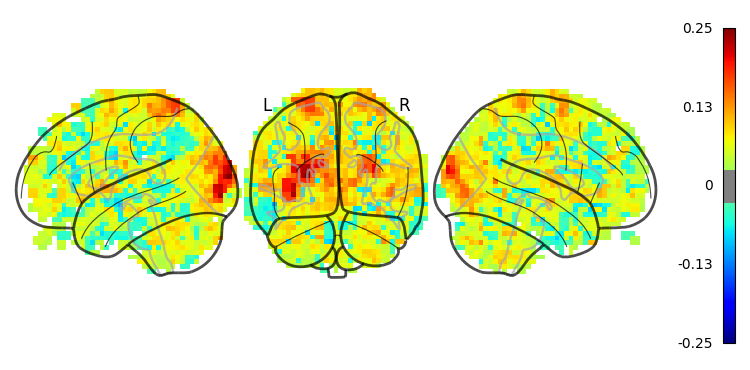

In [ ]:
# @title Visualing searchlight result
plotting.plot_glass_brain(nii_save_path, plot_abs=False, colorbar=True,
                          display_mode='lyr', cmap ="jet")

The images used in this experiment are in the *stimuli* directory. Using the images, one can also explore which artificial vision models have representation similar to navigational affordances,  or scene selective regions e.g., in [3].

# References

1. Bonner and Epstein, Coding of navigational affordances in the human visual system, PNAS 2017. doi: [10.1073/pnas.1618228114](https://doi.org/10.1073/pnas.1618228114)
2. Kriegeskorte et al., Representational similarity analysis – connecting the branches of systems neuroscience. Front. Syst. Neurosci. 2008. doi: [10.3389/neuro.06.004.2008](https://doi.org/10.3389/neuro.06.004.2008)
3. Bonner and Epstein, Computational mechanisms underlying cortical responses to the affordance properties of visual scenes. PLoS Comput. Biol. 2018. doi: [10.1371/journal.pcbi.1006111](https://doi.org/10.1371/journal.pcbi.1006111)